In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import time
from tensorflow.keras.regularizers import l2

from tensorflow.keras.layers import (Input, Dense, Lambda, Flatten, Reshape, BatchNormalization, 
                          Activation, Dropout, Conv2D, Conv2DTranspose,
                          Concatenate, Add, Multiply)
from flows import MaskingDense, IAF, MAF
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# 常用测试代码，勿执行勿删除
dataset=user_data
model = user_maf
training_steps=5
display_step=1

for step, (inputs, _y) in enumerate(dataset.take(training_steps + 1)):
    with tf.GradientTape() as g:
        z_k, e_0, _z_log_sigma_0, _z_sigmas = model.inference(inputs)
        x_hat, _z_sigmas_2 = model.generation(z_k)
            # 收敛非常快，暂时不知道原因
        loss = model.flow_loss(inputs, x_hat, e_0, _z_log_sigma_0, _z_sigmas, z_k)
    
    # 提高对重建的重视程度
    logpx_z = -model.metric(tf.keras.backend.flatten(inputs), tf.keras.backend.flatten(x_hat)) * model.original_size *5
    
    det = _z_log_sigma_0
    for z_sigma in _z_sigmas:
        det += tf.keras.backend.log(z_sigma)
    logqz_x = -tf.keras.backend.sum(0.5 * np.log(2*math.pi) + 0.5 * e_0 ** 2 + det, axis=-1)
    logqz_x = tf.reduce_mean(logqz_x)
    
    logpz = tf.reduce_mean(-tf.keras.backend.sum(0.5 * np.log(2*math.pi) + 0.5 * z_k ** 2, axis=-1))
    # # ELBO尽量大，故减小这个式子: - [logp(x|z) + logp(z) - logq(z|x)]
    flow_loss = -logpx_z - logpz + logqz_x
    print("logpx_z:%f  logqz_x:%f   logpz:%f"%(logpx_z, logqz_x, logpz))

NameError: name 'user_data' is not defined

# 超参数和数据集

整合全部的模型和训练内容

In [2]:
on_server = 1

# 影响最后RS的输出大小
batch_size = 64
# 生成的z的维度。如果要训练，则考虑选择更大的dim
latent_dim = 64
# maf和iaf的性能保证
num_flow = 7
learning_rate = 0.0001
# 在数据预处理的时候需要
# hottest = int(math.pow(25, 2))
hottest = 128
if on_server==1:
    dataset_path = r"E:\projects\recommend system\dataset\hetrec2011-lastfm-2k"
    saving_path = r"E:\projects\recommend system\recommend by normalizing flow"
else:
    dataset_path = r"E:\MyProjects\Dataset\hetrec2011-lastfm-2k"
    saving_path = r"E:\MyProjects\nf_rs\recommend by normalizing flow"

In [3]:
# load dataset
user_representation_normalized = pd.read_csv(dataset_path + "\\user_representation_sigmoid_128.csv" )
item_representation = pd.read_csv(dataset_path + "\\item_representation_1_128.csv" )

dataset_len = user_representation_normalized.shape[0]
id_list = np.arange(dataset_len) # 这里的类型是int32
user_data = tf.data.Dataset.from_tensor_slices((tf.cast(user_representation_normalized.values, 'float32'), id_list))

dataset_len = item_representation.shape[0]
id_list = np.arange(dataset_len)
item_data = tf.data.Dataset.from_tensor_slices((tf.cast(item_representation.values, 'float32'), id_list))

user_data = user_data.repeat().batch(batch_size).prefetch(1)
item_data = item_data.repeat().batch(batch_size).prefetch(1)

In [4]:
def save_load(op, model, obj, model_type, hyperparameter:list, path):
    """
    op, save or load
    path, model path
    obj, user or item
    model, model name iaf or maf or rs
    hyperparameter list
    rs model 暂时缺两个超参数
    """
    latent_dim, training_steps, batch_size, num_flow = hyperparameter
    place = saving_path + "\\128dim_sigmoid_BinaryCrossentropy_%d_%d_%d_%d\\%s_%s\\" % (latent_dim, training_steps, batch_size, num_flow, obj, model_type)
    if op == "save":
        tf.saved_model.save(model, place)
    elif op == "load":
        model = tf.saved_model.load(place)
        return model
    else:
        print("no such op")

# CAF的MAF部分

In [5]:
# 训练maf
def train_maf(maf, dataset:tf.data.Dataset, optimizer, training_steps=1000, display_step=100):
    loss_list = []
    for step, (inputs, _y) in enumerate(dataset.take(training_steps + 1)):
        with tf.GradientTape() as g:
            z_k, e_0, _z_log_sigma_0, _z_sigmas = maf.inference(inputs)
            x_hat, _z_sigmas_2 = maf.generation(z_k)
            # 收敛非常快，暂时不知道原因
            loss = maf.flow_loss(inputs, x_hat, e_0, _z_log_sigma_0, _z_sigmas, z_k, 10)
            
        loss_list.append(loss)
        if step % display_step == 0:
            print("step: %i, loss: %f" % (step, loss))
        gradients = g.gradient(loss, maf.variables)
        optimizer.apply_gradients(grads_and_vars=zip(gradients, maf.variables))
    return loss_list

In [6]:
user_maf = MAF(original_size=hottest, latent_dim=latent_dim, num_flow=num_flow)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

step: 0, loss: 699.505615
step: 300, loss: 400.767273
step: 600, loss: 294.318726
step: 900, loss: 245.649124
step: 1200, loss: 226.784149
step: 1500, loss: 203.396210
step: 1800, loss: 195.192322
step: 2100, loss: 182.670639
step: 2400, loss: 182.746979
step: 2700, loss: 172.880707
step: 3000, loss: 169.447937


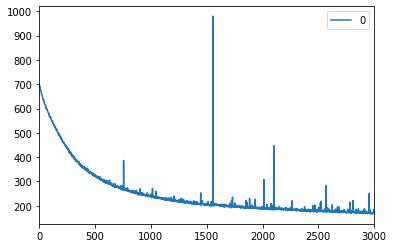

In [7]:
# 可反复执行训练部分
training_steps = 3000
display_step = 300
loss_list = train_maf(user_maf, dataset=user_data, optimizer=optimizer, 
                                       training_steps=training_steps, display_step=display_step)

p = pd.DataFrame(loss_list)
p.plot()

In [8]:
save_load(op='save', model=user_maf, obj='user', model_type='maf', 
          hyperparameter=[latent_dim, training_steps, batch_size, num_flow], path=saving_path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: E:\projects\recommend system\recommend by normalizing flow\128dim_sigmoid_BinaryCrossentropy_64_3000_64_7\user_maf\assets


In [9]:
item_maf = MAF(original_size=hottest, latent_dim=latent_dim, num_flow=num_flow)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

step: 0, loss: 698.996460
step: 300, loss: 416.788116
step: 600, loss: 310.674347
step: 900, loss: 260.262085
step: 1200, loss: 234.234436
step: 1500, loss: 219.344437
step: 1800, loss: 209.332123
step: 2100, loss: 192.114746
step: 2400, loss: 185.950821
step: 2700, loss: 177.254669
step: 3000, loss: 172.473511


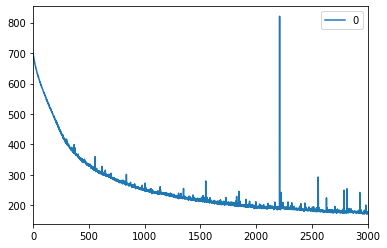

In [10]:
# 可反复执行训练部分
training_steps = 3000
display_step = 300
loss_list = train_maf(item_maf, dataset=user_data, optimizer=optimizer, 
                                       training_steps=training_steps, display_step=display_step)

p = pd.DataFrame(loss_list)
p.plot()

In [11]:
save_load(op='save', model=user_maf, obj='item', model_type='maf', 
          hyperparameter=[latent_dim, training_steps, batch_size, num_flow], path=saving_path)

INFO:tensorflow:Assets written to: E:\projects\recommend system\recommend by normalizing flow\128dim_sigmoid_BinaryCrossentropy_64_3000_64_7\item_maf\assets


In [12]:

user_maf = save_load(op='load', model=None, obj='user', model_type='maf', 
          hyperparameter=[latent_dim, training_steps, batch_size, num_flow], path=saving_path)
item_maf = save_load(op='load', model=None, obj='item', model_type='maf', 
          hyperparameter=[latent_dim, training_steps, batch_size, num_flow], path=saving_path)

# CAF的IAF部分

In [12]:
def train_iaf_with_trained_maf(iaf, maf, dataset:tf.data.Dataset, optimizer, training_steps=1000, display_step=100):
    loss_list = []
    for step, (inputs, _y) in enumerate(dataset.take(training_steps + 1)):
        with tf.GradientTape() as g:
            z_k, e_0, _z_log_sigma_0, _z_sigmas2 = maf.inference(inputs)
            
            z_k_i, e_0, _z_log_sigma_0, _z_sigmas = iaf.inference(inputs)
            
            x_hat, _z_sigmas = iaf.generation(z_k_i) # 不计算会说有些没有训练到，故而注释掉
            
            iaf_loss = iaf.flow_loss(inputs, x_hat, e_0, _z_log_sigma_0, _z_sigmas, z_k_i)
            
            # CAF eq 20。最后一层的sigma，代表z自身的熵 
            H_z = tf.reduce_mean(np.log(2*math.pi * _z_sigmas[-1]))
            # CAF eq 21。maf和iaf生成的熵
            
            # 交叉熵最好先做归一化，如果不归一化，这里的z的预测会急剧变成全负数。目前考虑的是用sigmoid
            # 在正常训练中没有出现，是因为会保证其z约束在正态分布上。联合训练也会负，但是不快
            z_k = tf.math.sigmoid(z_k)
            z_k_i = tf.math.sigmoid(z_k_i)
            H_maf_iaf = tf.reduce_mean(tf.keras.metrics.binary_crossentropy(z_k_i, z_k))
            
            loss =  H_z + H_maf_iaf + iaf_loss
            # 使用联合训练，iaf的loss下降很快，这里可以加入和直接iaf训练的对比图。因为求导的性质，也不需要担心对各个loss的减小的性能
            loss_list.append(iaf_loss)
        if step % display_step == 0:
            print("step: %i, H_z: %f, H_maf_iaf: %f, iaf_loss: %f" % (step, H_z, H_maf_iaf, iaf_loss))
        gradients = g.gradient(loss, iaf.variables)
        optimizer.apply_gradients(grads_and_vars=zip(gradients, iaf.variables))
    return loss_list

In [13]:
user_iaf = IAF(original_size=hottest, latent_dim=latent_dim, num_flow=num_flow)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

step: 0, H_z: 1.350573, H_maf_iaf: 0.733752, iaf_loss: 86918.046875
step: 300, H_z: 1.393090, H_maf_iaf: 0.733307, iaf_loss: 8431.243164
step: 600, H_z: 1.403063, H_maf_iaf: 0.714638, iaf_loss: 3321.378174
step: 900, H_z: 1.407569, H_maf_iaf: 0.706509, iaf_loss: 1828.402100
step: 1200, H_z: 1.409690, H_maf_iaf: 0.710369, iaf_loss: 1239.834473
step: 1500, H_z: 1.410833, H_maf_iaf: 0.716516, iaf_loss: 966.113403
step: 1800, H_z: 1.411638, H_maf_iaf: 0.709799, iaf_loss: 790.609741
step: 2100, H_z: 1.412670, H_maf_iaf: 0.718951, iaf_loss: 684.324524
step: 2400, H_z: 1.414901, H_maf_iaf: 0.712560, iaf_loss: 623.581482
step: 2700, H_z: 1.416591, H_maf_iaf: 0.711645, iaf_loss: 564.573608
step: 3000, H_z: 1.418636, H_maf_iaf: 0.709731, iaf_loss: 532.642761


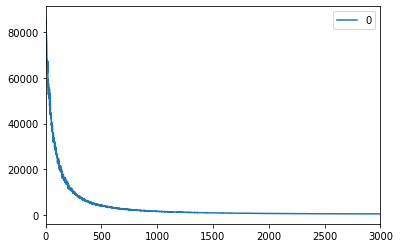

In [14]:
training_steps = 3000
display_step = 300
loss_list = train_iaf_with_trained_maf(user_iaf, user_maf, dataset=user_data, optimizer=optimizer, 
                                       training_steps=training_steps, display_step=display_step)

p = pd.DataFrame(loss_list)
p.plot()

In [15]:
save_load(op='save', model=user_iaf, obj='user', model_type='iaf', 
          hyperparameter=[latent_dim, training_steps, batch_size, num_flow], path=saving_path)

INFO:tensorflow:Assets written to: E:\projects\recommend system\recommend by normalizing flow\128dim_sigmoid_BinaryCrossentropy_64_3000_64_7\user_iaf\assets


In [16]:
item_iaf = IAF(original_size=hottest, latent_dim=latent_dim, num_flow=num_flow)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

step: 0, H_z: 1.348462, H_maf_iaf: 0.720234, iaf_loss: 77831.750000
step: 300, H_z: 1.382027, H_maf_iaf: 0.715748, iaf_loss: 7504.224121
step: 600, H_z: 1.393694, H_maf_iaf: 0.711738, iaf_loss: 2699.046631
step: 900, H_z: 1.397747, H_maf_iaf: 0.707977, iaf_loss: 1500.600830
step: 1200, H_z: 1.401913, H_maf_iaf: 0.707205, iaf_loss: 1043.592285
step: 1500, H_z: 1.404045, H_maf_iaf: 0.707040, iaf_loss: 804.571533
step: 1800, H_z: 1.406213, H_maf_iaf: 0.709514, iaf_loss: 692.491516
step: 2100, H_z: 1.408871, H_maf_iaf: 0.709143, iaf_loss: 582.363037
step: 2400, H_z: 1.410762, H_maf_iaf: 0.709410, iaf_loss: 542.290649
step: 2700, H_z: 1.413872, H_maf_iaf: 0.706365, iaf_loss: 483.676575
step: 3000, H_z: 1.415968, H_maf_iaf: 0.706537, iaf_loss: 461.573669


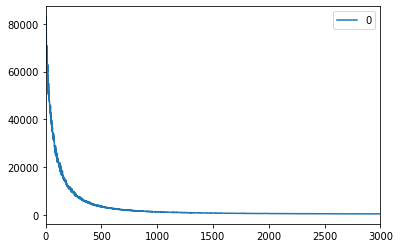

In [17]:
training_steps = 3000
display_step = 300
loss_list = train_iaf_with_trained_maf(item_iaf, item_maf, dataset=item_data, optimizer=optimizer, 
                                       training_steps=training_steps, display_step=display_step)

p = pd.DataFrame(loss_list)
p.plot()

In [18]:
save_load(op='save', model=item_iaf, obj='item', model_type='iaf', 
          hyperparameter=[latent_dim, training_steps, batch_size, num_flow], path=saving_path)

INFO:tensorflow:Assets written to: E:\projects\recommend system\recommend by normalizing flow\128dim_sigmoid_BinaryCrossentropy_64_3000_64_7\item_iaf\assets


In [7]:
user_iaf = save_load(op='load', model=None, obj='user', model_type='iaf', 
          hyperparameter=[latent_dim, training_steps, batch_size, num_flow], path=saving_path)
item_iaf = save_load(op='load', model=None, obj='item', model_type='iaf', 
          hyperparameter=[latent_dim, training_steps, batch_size, num_flow], path=saving_path)

# RS部分

这里是准备标签，标签是训练的时候决定的

In [19]:
user_tag = pd.read_table(dataset_path + "\\user_taggedartists.dat")
user_original_id = user_tag.drop_duplicates(subset='userID', keep='first', inplace=False).reset_index(drop=True)
item_original_id = user_tag.drop_duplicates(subset='artistID', keep='first', inplace=False).reset_index(drop=True)

user_artists = pd.read_table(dataset_path + "\\user_artists.dat")
user_artists_grouped = user_artists.groupby('userID').groups

def get_y_true(x_id, y_id, batch_size):
    label = np.zeros(shape=(batch_size, batch_size))
    for x in x_id.numpy():
        x = int(x)
        origin_user_id = user_original_id.iloc[x]['userID']
    
        for y in y_id.numpy():
            y = int(y)
            origin_item_id = item_original_id.iloc[y]['artistID']
        
            # 找到这个user是否有订阅这个item
            if origin_item_id in user_artists_grouped[origin_user_id].values:
                label[x%batch_size][y%batch_size] = 1
    # label[x][y] 表示 user x 对 y 的兴趣程度。每次输入都是一个batch，所以label取余就可以得到正确的xy坐标
    return label.astype(np.float32)

In [20]:
class RS(tf.keras.Model):
    def __init__(self, input_size, output_size=256, num_nn=4):
        """
        input_size是user和item叠加在一起的形状，batch_size * 2latent_dim
        output_size是user和item的交互信息，batch_size * batch_size
        """
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.num_nn = num_nn
        
        self.dense = []
        for i in range(self.num_nn):
            self.dense.append(Dense(units=self.output_size, activation=tf.nn.leaky_relu))
            
        self.out = Dense(units=self.output_size, activation=tf.nn.leaky_relu)
        self.act = tf.nn.sigmoid
        # 因为weighted_cross_entropy_with_logits里面会有sigmoid
        self.matrics = tf.nn.weighted_cross_entropy_with_logits
        # self.matrics = tf.keras.metrics.binary_crossentropy
    
    @tf.function
    def call(self, inputs): 
        # inputs is [batch_size, 2latent_dim], outputs is [batch_size, batch_size]
        for i in range(self.num_nn):
            inputs = self.dense[i](inputs)
            
        outputs = self.out(inputs)
        
        return outputs
    
    @tf.function
    def act(self, inputs): 
        self.act(inputs)
        return self.act(inputs)
    
    @tf.function
    def RSloss(self, y_true, y_pred, pos_weight=5):
        y_pred = tf.keras.backend.flatten(y_pred)
        y_true = tf.keras.backend.flatten(y_true)
        # loss = tf.keras.metrics.binary_crossentropy(y_true, y_pred)
        # 要提高召回率，即降低将1预测0的概率，提高将1预测成1的概率。pos_weight > 1
        loss = self.matrics(labels=y_true,logits=y_pred, pos_weight=pos_weight)
        
        return tf.math.reduce_mean(loss)

In [21]:
num_nn = 5
rs = RS(input_size=latent_dim*2, output_size=batch_size, num_nn=num_nn)

In [22]:
learning_rate = 0.0001
training_steps = 3000
display_step = 300
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

step: 0, loss: 319256.500000
step: 300, loss: 33425.039062
step: 600, loss: 1339.435059
step: 900, loss: 1138.825562
step: 1200, loss: 1137.903564
step: 1500, loss: 1443.671753
step: 1800, loss: 1113.817383
step: 2100, loss: 9953.241211
step: 2400, loss: 4515.781250
step: 2700, loss: 1258.804810
step: 3000, loss: 866.146484


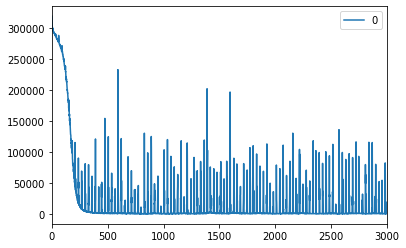

In [24]:
a = enumerate(user_data.take(training_steps + 1))
b = enumerate(item_data.take(training_steps + 1))
loss_list = []
for ((step, i), (step,j)) in zip(a, b):
    with tf.GradientTape() as g:
        (user, x_id) = i
        (item, y_id) = j
    
        user, e_0, _z_log_sigma_0, _z_sigmas = user_iaf.inference(user)
        item, e_0, _z_log_sigma_0, _z_sigmas = item_iaf.inference(item)
    
        # 经过一番折腾得到最终的表示，batch_size * latent_dim，再叠起来得到 batch_size * 2latent_dim
        conbine = tf.keras.backend.concatenate((user, item), axis=1)
    
        # 输出是 batch_size * batch_size
        y_pred = rs.call(conbine)
        y_pred_sigmoid = rs.act(y_pred)
        
        y_true = get_y_true(x_id, y_id, batch_size)
    
        loss = rs.RSloss(y_true, y_pred)
        # todo
        loss = loss*batch_size*batch_size*100
        loss_list.append(loss)
        if step % display_step == 0:
            print("step: %i, loss: %f" % (step, loss))
            
    gradients = g.gradient(loss, rs.variables)
    optimizer.apply_gradients(grads_and_vars=zip(gradients, rs.variables))
    
p = pd.DataFrame(loss_list)
p.plot()

还没保存

In [25]:
save_load(op='save', model=rs, obj='rs', model_type='rs', 
          hyperparameter=[latent_dim, training_steps, batch_size, num_flow], path=saving_path)

INFO:tensorflow:Assets written to: E:\projects\recommend system\recommend by normalizing flow\128dim_sigmoid_BinaryCrossentropy_64_3000_64_7\rs_rs\assets


真实数据太稀疏了，否则训练的label全是0

1. 数据增强，将正向的数据反复进行训练
2. 加强权重。weighted_cross_entropy_with_logits


训练好了再用其他方法来检测推荐准确度。

数据集中有联系的，基本上应该都能预测出来，但是没有的，也会预测出来，这里就涉及到了真假阳性的问题了，应该和训练时间也有关系，过拟合了就肯定有问题。

# evaluate

a>=threshold 的都是检测出来positive，y_true==1 的都是true。

但是按照推荐系统的理念，P应该要更多才符合标准

即user没有标，但是系统标了 FP 大，TP 大。

反之，不能将别人认为感兴趣的标成N，即FN要小。

同理，TN要大，将别人不感兴趣的标成不感兴趣的。

FP就是需要推荐的内容。

In [26]:
def evaluate(rs_model, training_steps, TP, FP, TN, FN, user_data, item_data, threshold=0.0001):
    a = enumerate(user_data.take(training_steps))
    b = enumerate(item_data.take(training_steps))
    for ((step, i), (step,j)) in zip(a, b):
        (user, x_id) = i
        (item, y_id) = j
        user, e_0, _z_log_sigma_0, _z_sigmas = user_iaf.inference(user)
        item, e_0, _z_log_sigma_0, _z_sigmas = item_iaf.inference(item)
        conbine = tf.keras.backend.concatenate((user, item), axis=1)
        
        # 输出是 batch_size * batch_size
        y_pred = rs_model.call(conbine)
        y_pred_sigmoid = rs_model.act(y_pred)
        
        y_true = get_y_true(x_id, y_id, batch_size)
    
        XP = y_true[y_pred_sigmoid>=threshold]  # 预测出来是 positive 的数量
        XN = y_true[y_pred_sigmoid<threshold]  # 预测出来是 negative 的数量
    
        TP += np.sum(XP) # 预测出来是positive，实际上是true的数量
        FP += XP.shape[0] - np.sum(XP)
        # 预测0，但是实际是1，即为FN
        FN += np.sum(XN)
        TN += XN.shape[0] - np.sum(XN)
    
    return TP, FP, TN, FN

In [27]:
threshold = 0.0001
training_steps = 5000

TP = FP = TN = FN = 0

In [28]:
TP, FP, TN, FN = evaluate(rs, training_steps, TP, FP, TN, FN, user_data, item_data, threshold=0.0001)
Precision = TP / (TP + FP)
Recall = TP / (TP + FN)
F1 = 2*Precision*Recall/ (Precision+Recall)
print("Precision:%f, Recall:%f, F1:%f" %(Precision, Recall, F1))
print("TP:%d, FP:%d, FN:%d, TN:%d。    参考，FP和TP接近甚至更小，FN尽量小"%(TP, FP, FN, TN))

Precision:0.000523, Recall:0.999627, F1:0.001046
TP:10710.000000, FP:20462854.000000, TN:6432.000000, FN:4.000000。    参考，前三大，FN小


看出系统倾向于标正类，导致精确度特别低,所以，提高衡量标准看看

In [30]:
threshold = 0.000075
training_steps = 5000

TP = FP = TN = FN = 0

TP, FP, TN, FN = evaluate(rs, training_steps, TP, FP, TN, FN, user_data, item_data, threshold=threshold)

Precision = TP / (TP + FP)
Recall = TP / (TP + FN)
F1 = 2*Precision*Recall/ (Precision+Recall)
print("Precision:%f, Recall:%f, F1:%f" %(Precision, Recall, F1))
print("TP:%d, FP:%d, FN:%d, TN:%d。    参考，FP和TP接近甚至更小，FN尽量小"%(TP, FP, FN, TN))

Precision:0.000523, Recall:1.000000, F1:0.001046
TP:10714, FP:20466839, FN:0, TN:2447。    参考，FP和TP接近甚至更小，FN尽量小


In [31]:
threshold = 0.00005
training_steps = 5000

TP = FP = TN = FN = 0

TP, FP, TN, FN = evaluate(rs, training_steps, TP, FP, TN, FN, user_data, item_data, threshold=threshold)

Precision = TP / (TP + FP)
Recall = TP / (TP + FN)
F1 = 2*Precision*Recall/ (Precision+Recall)
print("Precision:%f, Recall:%f, F1:%f" %(Precision, Recall, F1))
print("TP:%d, FP:%d, FN:%d, TN:%d。    参考，FP和TP接近甚至更小，FN尽量小"%(TP, FP, FN, TN))

Precision:0.000523, Recall:1.000000, F1:0.001046
TP:10714, FP:20469044, FN:0, TN:242。    参考，FP和TP接近甚至更小，FN尽量小


不断提高的阈值的结果是精确度下降很少，但是recall下降特别快。我的目的是降低FP，即尽量不要推荐太多东西，但是同时，FN又上升太快了，TP下降FN上升，recall就下降很快